# Panikos Christou Internship notebook

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import networkx as nx
import numpy as np
from sklearn.utils import shuffle
import nltk
from nltk.tokenize import TweetTokenizer
import random
from operator import itemgetter
import itertools
import copy
from feature_selector import FeatureSelector
import pymongo


## Opening the dataset

In [2]:
training_data_location = os.path.join(
    "D:/affiliated_acounts",
    "Data",
    "stance-data",
    "data-all-annotations",
    "trainingdata-all-annotations.txt",
)
test_data_a_location = os.path.join(
    "D:/affiliated_acounts",
    "Data",
    "stance-data",
    "data-all-annotations",
    "testdata-taskA-all-annotations.txt",
)
test_data_b_location = os.path.join(
    "D:/affiliated_acounts",
    "Data",
    "stance-data",
    "data-all-annotations",
    "testdata-taskB-all-annotations.txt",
)
# todo test data aswell
file1 = open(training_data_location, "r")
file2 = open(test_data_a_location, "r")
file3 = open(test_data_b_location, "r")

In [3]:
dataset = pd.read_csv(file1, sep="\t")
dataset.append(pd.read_csv(file2, sep="\t"))
dataset.append(pd.read_csv(file3, sep="\t"))
# append here
print(dataset.head())
dataset.count()

    ID   Target                                              Tweet   Stance  \
0  101  Atheism  dear lord thank u for all of ur blessings forg...  AGAINST   
1  102  Atheism  Blessed are the peacemakers, for they shall be...  AGAINST   
2  103  Atheism  I am not conformed to this world. I am transfo...  AGAINST   
3  104  Atheism  Salah should be prayed with #focus and #unders...  AGAINST   
4  105  Atheism  And stay in your houses and do not display you...  AGAINST   

  Opinion towards Sentiment  
0           OTHER  POSITIVE  
1           OTHER  POSITIVE  
2           OTHER  POSITIVE  
3           OTHER  POSITIVE  
4           OTHER  NEGATIVE  


ID                 2814
Target             2814
Tweet              2814
Stance             2814
Opinion towards    2814
Sentiment          2814
dtype: int64

In [4]:
def get_data_of_target(target):
    return dataset[dataset["Target"] == target]


def get_data_of_target_form_dataset(target, dataset):
    return dataset[dataset["Target"] == target]


print(get_data_of_target("Hillary Clinton").head())
print()
print(len(get_data_of_target("Hillary Clinton")))


def get_mentions(tweet):
    found = []
    matches = re.findall(regex_mention, tweet)
    if matches:
        found = [("@" + match) for match in matches]
    return found

        ID           Target  \
1572  1673  Hillary Clinton   
1573  1674  Hillary Clinton   
1574  1675  Hillary Clinton   
1575  1676  Hillary Clinton   
1576  1677  Hillary Clinton   

                                                  Tweet   Stance  \
1572  RT @GunnJessica: Because I want young American...    FAVOR   
1573  @Chris_1791 @newsbusters 2 years ago #Hillary ...  AGAINST   
1574  @dnewhauser take that, Marco Rubio. @GOP canno...     NONE   
1575  @StateDept @AmbCathyRussell @AdamSmith_USA @Hi...    FAVOR   
1576  Lets remember #dickcheney is an unindicted war...     NONE   

     Opinion towards Sentiment  
1572           OTHER  POSITIVE  
1573          TARGET  NEGATIVE  
1574           OTHER  NEGATIVE  
1575          TARGET  POSITIVE  
1576           OTHER  NEGATIVE  

639


## regex to extract all mentions and hshtags from a tweet

In [5]:
regex_mention = re.compile(r"(?<=^|(?<=[^a-zA-Z0-9-_.]))@([A-Za-z]+[A-Za-z0-9-_]+)")
regex_hashtag = re.compile(r"(?<=^|(?<=[^a-zA-Z0-9-_.]))#([A-Za-z]+[A-Za-z0-9-_]+)")

## Graph making skills testing ground which will help later

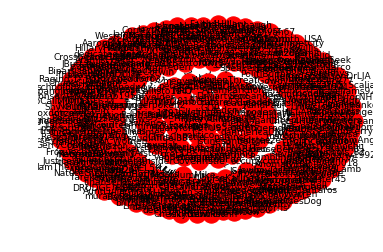

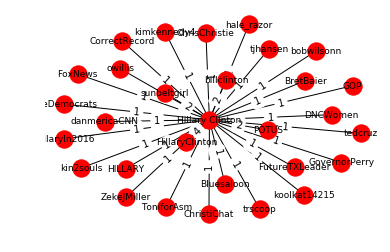

In [6]:
def create_a_graph_of_mentions_no_data_specified(
    target, print_it=False, percentage_of_data=0
):
    G = nx.Graph()
    if not percentage_of_data:
        data = get_data_of_target(target)
    else:
        data = get_data_of_target(target)
        data = data.sample(n=int(percentage_of_data * len(data["Tweet"])))
    for tweet in data["Tweet"]:
        matches = re.findall(regex_mention, tweet)
        if matches:
            for match in matches:
                if G.has_edge(target, match):
                    G.add_edge(target, match, weight=G[target][match]["weight"] + 1)
                else:
                    G.add_edge(target, match, weight=1)
    if print_it:
        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")
        nx.draw(G, pos)
        labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()
    return G


target = "Hillary Clinton"
G1 = create_a_graph_of_mentions_no_data_specified(target, print_it=True)
G2 = create_a_graph_of_mentions_no_data_specified(
    target, print_it=True, percentage_of_data=0.05
)

## testing to where i learned to to sort the edges and the the centrality of nodes of the graph. We will explain later what they are and why they are needed.

In [7]:
def sorted_centrality(G1):
    centrality = nx.betweenness_centrality(G1)
    sorted_by_centrality = sorted(centrality, key=lambda x: centrality[x], reverse=True)
    sorted_by_centrality_with_values = [
        [i, centrality[i]] for i in sorted_by_centrality
    ]
    return sorted_by_centrality_with_values


print(sorted_centrality(G1)[:5])

[['Hillary Clinton', 1.0], ['GunnJessica', 0.0], ['Chris_1791', 0.0], ['newsbusters', 0.0], ['dnewhauser', 0.0]]


In [8]:
def sorted_edges(G1):
    sorted_edges = sorted(
        G1.edges(data=True), key=lambda t: t[2].get("weight", 1), reverse=True
    )
    return sorted_edges


print(sorted_edges(G1)[:5])

[('Hillary Clinton', 'HillaryClinton', {'weight': 118}), ('Hillary Clinton', 'POTUS', {'weight': 15}), ('Hillary Clinton', 'billclinton', {'weight': 14}), ('Hillary Clinton', 'GOP', {'weight': 8}), ('Hillary Clinton', 'BarackObama', {'weight': 8})]


# Manualy did some data

## code that reads manual data and saves them to a pandas dict of lists

In [9]:
manual_data = pd.read_csv("manual_data_updated.csv", index_col=0)
print(manual_data.head())
print("\n\n")
data = {"target": [], "account": [], "affiliated": []}
for index, row in manual_data.iterrows():
    data["target"].append(row[0])
    data["account"].append(row[1])
    data["affiliated"].append(row[2])
print(len(data["target"]))

              target         account  affiliated
0    Hillary Clinton  HillaryClinton        True
411  Hillary Clinton      JW4Hillary        True
125  Hillary Clinton        DNCWomen        True
164  Hillary Clinton   ClintonGlobal        True
300  Hillary Clinton    HillaryforSC        True



363



### Also a function that returns all the mentions in the dataset

In [10]:
def get_mentions_from_tweets_from_dataset(target):
    all_mentions = []
    Hillary_tweets = get_data_of_target(target)["Tweet"]
    for tweet in Hillary_tweets:
        mentions = get_mentions(tweet)
        if mentions:
            for i in mentions:
                all_mentions.append(i[1:])  # no hashtag
    return all_mentions

## now that we have the manual data the code belows sees all the mentions and if a mention from the dataset wasnt manually checked then it asks  the user to fill it. When you exit it updates the csv file
### uncomment it if you want to add users to dasates and manualy check them

In [11]:
# df = pd.read_csv("manual_data.csv",index_col = 0)
# df = df.sort_values(["affiliated",], ascending = (False))
# df = df.drop_duplicates(subset='account', keep="first")

# print(df)
# print(len(df))

# all_mentions = get_mentions_from_tweets_from_dataset('Hillary Clinton')

# for account in all_mentions:
#     if account in data['account']:continue
#     is_affiliated = input(('Is ',"Hillary Clinton", " affiliated with ",account," ?"))
#     if  is_affiliated == 'y' :
#         data['target'].append(account[0])
#         data['account'].append(account[1])
#         data['affiliated'].append(True)
#     else:
#         if  is_affiliated == 'exit': break
#         data['target'].append(account[0])
#         data['account'].append(account[1])
#         data['affiliated'].append(False)
# df = pd.DataFrame(data=data)
# df.to_csv("manual_data_updated.csv")
# print(len(data['target']))
# print(data)

## NLP proccessing testing ground

In [12]:
tknzr = TweetTokenizer()
Hillary_tweets = get_data_of_target("Hillary Clinton")["Tweet"]
tokenized_tweets = [tknzr.tokenize(t) for t in Hillary_tweets]
print(tokenized_tweets[:1])

[['RT', '@GunnJessica', ':', 'Because', 'I', 'want', 'young', 'American', 'women', 'to', 'be', 'able', 'to', 'be', 'proud', 'of', 'the', '1st', 'woman', 'president', '#SemST']]


In [13]:
pos_tweets = [nltk.pos_tag(tweet) for tweet in tokenized_tweets]
pos_tweets[11]

[("Didn't", 'NNP'),
 ('realize', 'VB'),
 ('Bob', 'NNP'),
 ('Dole', 'NNP'),
 ('was', 'VBD'),
 ('mentioned', 'VBN'),
 ('in', 'IN'),
 ("Tupac's", 'NNP'),
 ('"', 'NNP'),
 ('How', 'NNP'),
 ('do', 'VBP'),
 ('u', 'JJ'),
 ('want', 'VB'),
 ('it', 'PRP'),
 ('"', 'JJ'),
 ('#YesterdaysLeaders', 'NNS'),
 ('#SemST', 'VBP')]

In [14]:
# Create the named entity chunks: chunked_sentences
chunked_tweets = nltk.ne_chunk_sents(pos_tweets, binary=True)
NERS = []
for chunked_tweet in chunked_tweets:
    for word in chunked_tweet:
        if hasattr(word, "label") and word.label() == "NE":
            NERS.append(word)
NERS[:15]

[Tree('NE', [('RT', 'NNP')]),
 Tree('NE', [('American', 'JJ')]),
 Tree('NE', [('Marco', 'NNP'), ('Rubio', 'NNP')]),
 Tree('NE', [('Latino', 'NNP')]),
 Tree('NE', [('Human', 'NNP')]),
 Tree('NE', [('Clinton', 'NNP')]),
 Tree('NE', [('Bill', 'NNP'), ('Clinton', 'NNP')]),
 Tree('NE', [('Bob', 'NNP'), ('Dole', 'NNP')]),
 Tree('NE', [('Oval', 'NNP'), ('Office', 'NNP')]),
 Tree('NE', [('SOS', 'NNP')]),
 Tree('NE', [('RT', 'NNP')]),
 Tree('NE', [('SEXIST', 'NNP')]),
 Tree('NE', [('Low', 'JJ')]),
 Tree('NE', [('Iraq', 'NNP')]),
 Tree('NE', [('Does', 'NNP')])]

# Co-occurence graph V2.0 using Named entities to create a graph instead of mentions

## below we create a set of all sigle word entities

In [15]:
list_of_list_entities = [i[:] for i in NERS]
# print(list_of_list_entities[:5])
temp = ""
entities = []
for list_entities in list_of_list_entities:
    temp = ""
    for string in list_entities:
        temp = temp + string[0] + " "
    entities.append(temp[:-1])
set_entities = set(entities)
print(random.sample(set_entities, 5))

['CHANGE', 'Hahahaha', 'Hill', 'Ambassador', 'EQUALITY']


## updated the above to a function that now also recognizes multi word entities and tested it. 

In [16]:
tknzr = TweetTokenizer()
# lets make it a function that takes in a sentence and prints out as above all ners in it
def get_entities(tweet):
    pos_test = nltk.pos_tag(tknzr.tokenize(tweet))
    #    print(pos_test)
    chunked_tweet = nltk.ne_chunk(pos_test)
    #    print(chunked_tweet)
    NERS = []
    for word in chunked_tweet:
        if hasattr(word, "label"):
            NERS.append(word)
    #    print(NERS)
    temp = ""
    entities = []
    for list_entities in NERS:
        temp = ""
        for string in list_entities:
            temp = temp + string[0] + " "
        entities.append(temp[:-1])
    #    print(entities)
    return entities


string_test = "Didn't realize Hillary Clinton with Bob Dole was mentioned in Tupac's \"How do u want it\" #YesterdaysLeaders"

get_entities(string_test)

['Hillary Clinton', 'Bob Dole']

### make them lowercase to avoid "Hillary" being different from "hillary"

In [17]:
entities_lower = [i.lower() for i in entities]
entities_lower[:5]
set_entities = set(entities_lower)
set_entities

{'#hillaryclinton',
 '@autumnnalston',
 '@hillaryclinton',
 '@hillaryclinton awesome',
 '@hillaryclinton did',
 '@hillaryclinton hahahaha',
 "@hillaryclinton i'd",
 '@hillaryclinton pretty',
 '@hillaryclinton r',
 '@hillaryclinton so',
 '@hillaryclinton stop',
 '@hillaryclinton will',
 'aaron hernandez',
 'aca',
 'adolph hitler',
 'again',
 'al qaeda',
 'all',
 'always',
 'amb stevens',
 'ambassador',
 'america',
 'america weekend',
 'american',
 'americans',
 'americans welfare checks',
 'andrew fastow',
 'apple',
 'australia',
 'back',
 'baltimore',
 'benghazi',
 'bern',
 'bernie',
 'bernie sanders',
 'bethesda',
 'big',
 'bill',
 'bill clinton',
 'bill clinton decided',
 'bin laden',
 'bingo',
 'black',
 'blacks',
 'bliss studio',
 'bob dole',
 'bogus',
 'bosnia',
 'brew house',
 'broke',
 'bush',
 'button',
 'cabinet secretaries',
 'california',
 'campaign slogan',
 'canada',
 'cancer',
 'cant',
 'care',
 'change',
 'chelsea',
 'chester',
 'chicago',
 'china',
 'chipotle',
 'chris 

# Now that we practised finding NERS lets make the real graph
## functions that create pgraph for use later

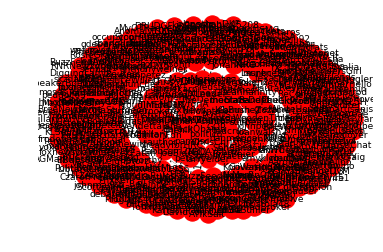

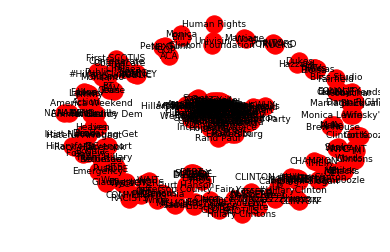

In [18]:
def create_a_graph_of_number_of_times_user_is_tweeted(
    target, dataset, print_it=False, percentage_of_data=0, regex=regex_mention
):
    G = nx.Graph()
    data = get_data_of_target_form_dataset(target, dataset)
    if percentage_of_data:
        data = data.sample(n=int(percentage_of_data * len(data["Tweet"])))
    for tweet in data["Tweet"]:
        matches = re.findall(regex, tweet)
        if matches:
            for match in matches:
                if G.has_edge(target, match):
                    G.add_edge(target, match, weight=G[target][match]["weight"] + 1)
                else:
                    G.add_edge(target, match, weight=1)
    if print_it:
        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")
        nx.draw(G, pos)
        labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()
    return G


G_mentions = create_a_graph_of_number_of_times_user_is_tweeted(
    "Hillary Clinton", dataset, True
)


def create_a_graph_of_entities(target, dataset, print_it=False, percentage_of_data=0):
    G = nx.Graph()
    data = get_data_of_target_form_dataset(target, dataset)
    if percentage_of_data:
        data = data.sample(n=int(percentage_of_data * len(data["Tweet"])))
    for tweet in data["Tweet"]:
        entities = get_entities(tweet)
        if entities:
            #         for entity in entities:
            for pair in itertools.combinations(entities, 2):
                #             clone = entities.copy()
                #             clone.remove(entity)
                #             for entity_secondary in clone:
                entity = pair[0]
                entity_secondary = pair[1]
                if G.has_edge(entity, entity_secondary):
                    G.add_edge(
                        entity,
                        entity_secondary,
                        weight=G[entity][entity_secondary]["weight"] + 1,
                    )
                else:
                    G.add_edge(entity, entity_secondary, weight=1)

    if print_it:
        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")
        nx.draw(G, pos)
        labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()
    return G


G_entities = create_a_graph_of_entities("Hillary Clinton", dataset, True)

## functions for graph analysis  with sorted results for later use

In [19]:
##Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
def sorted_centrality(graph):
    centrality = nx.betweenness_centrality(graph)
    
    sorted_by_centrality = sorted(centrality, key=lambda x: centrality[x], reverse=True)
    sorted_by_centrality_with_values = [
        [i, centrality[i]] for i in sorted_by_centrality
    ]
    return sorted_by_centrality_with_values


sorted_centrality(G_mentions)[:5]

[['Hillary Clinton', 1.0],
 ['GunnJessica', 0.0],
 ['Chris_1791', 0.0],
 ['newsbusters', 0.0],
 ['dnewhauser', 0.0]]

In [20]:
def sorted_edge_centrality(graph):
    edge_centrality = nx.edge_betweenness_centrality(graph)
    sorted_by_edge_centrality = sorted(
        edge_centrality, key=lambda x: edge_centrality[x], reverse=True
    )
    sorted_by_centrality_with_values = [
        [i, edge_centrality[i]] for i in sorted_by_edge_centrality
    ]
    return sorted_by_centrality_with_values


sorted_edge_centrality(G_mentions)[:5]

[[('Hillary Clinton', 'GunnJessica'), 0.005494505494505495],
 [('Hillary Clinton', 'Chris_1791'), 0.005494505494505495],
 [('Hillary Clinton', 'newsbusters'), 0.005494505494505495],
 [('Hillary Clinton', 'dnewhauser'), 0.005494505494505495],
 [('Hillary Clinton', 'GOP'), 0.005494505494505495]]

In [21]:
# Closeness centrality 1 of a node u is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes.
def sorted_closeness_centrality(graph):
    edge_centrality = nx.closeness_centrality(graph)
    sorted_by_edge_centrality = sorted(
        edge_centrality, key=lambda x: edge_centrality[x], reverse=True
    )
    sorted_by_centrality_with_values = [
        [i, edge_centrality[i]] for i in sorted_by_edge_centrality
    ]
    return sorted_by_centrality_with_values


sorted_closeness_centrality(G_mentions)[:5]

[['Hillary Clinton', 1.0],
 ['GunnJessica', 0.5006896551724138],
 ['Chris_1791', 0.5006896551724138],
 ['newsbusters', 0.5006896551724138],
 ['dnewhauser', 0.5006896551724138]]

In [22]:
def sorted_pagerank_centrality(graph):
    edge_centrality = nx.pagerank(graph)
    sorted_by_edge_centrality = sorted(
        edge_centrality, key=lambda x: edge_centrality[x], reverse=True
    )
    sorted_by_centrality_with_values = [
        [i, edge_centrality[i]] for i in sorted_by_edge_centrality
    ]
    return sorted_by_centrality_with_values


sorted_pagerank_centrality(G_mentions)[:5]

[['Hillary Clinton', 0.45976520573668056],
 ['HillaryClinton', 0.07573289199165942],
 ['POTUS', 0.009986766396779204],
 ['billclinton', 0.009348454497799785],
 ['GOP', 0.005518583103923268]]

In [23]:
# degree_centrality which is defined as the number of links incident upon a node
def sorted_by_degree_centrality(graph):
    degree_centrality = nx.degree_centrality(graph)
    sorted_by_degree_centrality = sorted(
        degree_centrality, key=lambda x: degree_centrality[x], reverse=True
    )
    sorted_by_degree_centrality_with_values = [
        [i, degree_centrality[i]] for i in sorted_by_degree_centrality
    ]
    return sorted_by_degree_centrality_with_values


sorted_by_degree_centrality(G_mentions)[:5]

[['Hillary Clinton', 1.0],
 ['GunnJessica', 0.0027548209366391185],
 ['Chris_1791', 0.0027548209366391185],
 ['newsbusters', 0.0027548209366391185],
 ['dnewhauser', 0.0027548209366391185]]

In [24]:
# Eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network.
# It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes
# contribute more to the score of the node in question than equal connections to low-scoring nodes.
def sorted_by_eigenvector_centrality(graph):
    try:
        eigenvector_centrality = nx.eigenvector_centrality(graph)
        sorted_by_eigenvector_centrality = sorted(
            eigenvector_centrality,
            key=lambda x: eigenvector_centrality[x],
            reverse=True,
        )
        sorted_by_eigenvector_centrality_with_values = [
            [i, eigenvector_centrality[i]] for i in sorted_by_eigenvector_centrality
        ]
        return sorted_by_eigenvector_centrality_with_values
    except nx.exception.PowerIterationFailedConvergence:
        return None


temp = sorted_by_eigenvector_centrality(G_mentions)
if temp:
    print(temp[:5])

### Helper function to help with getting the hashtags

In [25]:
def get_list_of_hashtags(tweet):
    found = []
    matches = re.findall(regex_hashtag, tweet)
    if matches:
        found = [("#" + match) for match in matches]
    return found

### I will create a dictionary which will map the pair of entities i.e. @hillaryclinton and @barackobama with another dictionary with a list of the tweets, a list of their respective sentiments, the number of hashtags, a list of the hashtags, number of user mentions, a list of usermentions and if its a retweet if that tweet has them both together in its text.

In [26]:
dict_of_pairs = {}
data_of_Hillary = get_data_of_target("Hillary Clinton")
print(len(data_of_Hillary))
mentions_with_more_than_1_mention = 0
for index, row in data_of_Hillary.iterrows():
    mentions = get_mentions(row["Tweet"])
    if len(mentions) > 1:
        mentions_with_more_than_1_mention += 1
        hashtags = get_list_of_hashtags(row["Tweet"])
        for pair in itertools.combinations(mentions, 2):
            mention = pair[0]
            mention_secondary = pair[1]
            key = (mention, mention_secondary)
            if key in dict_of_pairs:  # if pair already exists
                dict_of_pairs[key]["list_of_tweets"].append(row["Tweet"])
                dict_of_pairs[key]["list_of_sentiments"].append(row["Sentiment"])
                dict_of_pairs[key]["list_of_Stances"].append(row["Stance"])
                dict_of_pairs[key]["list_of_Opinion_Towards"].append(
                    row["Opinion towards"]
                )
                dict_of_pairs[key]["list_of_list_of_user_mentions"].append(mentions)
                dict_of_pairs[key]["list_of_num_hashtags"].append(len(hashtags))
                dict_of_pairs[key]["list_of_list_of_the_hashtags"].append(hashtags)
                dict_of_pairs[key]["number_of_the_user_mentions"].append(len(mentions))
                dict_of_pairs[key]["retweet"].append(
                    True if row["Tweet"][0:2] == "RT" else False
                )

            else:  # if pair does not already exists
                dict_of_pairs[key] = {
                    "list_of_tweets": [row["Tweet"]],
                    "list_of_sentiments": [row["Sentiment"]],
                    "list_of_Stances": [row["Stance"]],
                    "list_of_Opinion_Towards": [row["Opinion towards"]],
                    "list_of_num_hashtags": [len(hashtags)],
                    "list_of_list_of_the_hashtags": [hashtags],
                    "number_of_the_user_mentions": [len(mentions)],
                    "list_of_list_of_user_mentions": [mentions],
                    "retweet": [True if row["Tweet"][0:2] == "RT" else False],
                }
# matplotlib everything to show better and compare with mine vs data
# mine affilited finnd in here and compare with the not
# print(dict_of_pairs)
nums = dict_of_pairs.items()
print(mentions_with_more_than_1_mention)
print(len(nums))
sorted_nums = sorted(nums, key=lambda x: len(x[1]["list_of_tweets"]), reverse=True)
list_nums = [
    str(i) + "\n\n " + str(len(i[1]["list_of_tweets"])) + "\n " for i in sorted_nums
]
for i in list_nums:
    print(i)
    print()

639
137
393
(('@HillaryClinton', '@billclinton'), {'list_of_tweets': ['@Network_Citizen @ProudInfidel33 @YoungBLKRepub "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@sunbeltgirl @9975Ts @bobwilsonn "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #StopHillary2016 #SemST', '@WoodenThreat @ProudInfidel33 "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@kin2souls @sunbeltgirl @ChristiChat "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@RedStateJake "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #SemST', '@Babbsgirl2 "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #SemST', '@ResistTyranny "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHilla

## Getting Hillarys  connections sorted to check up if we are doing ok

In [27]:
hillary_with_other = []
for i in sorted_nums:
    if i[0][0] == "@HillaryClinton" or i[0][1] == "@HillaryClinton":
        hillary_with_other.append(i)
hillary_with_other_printable = [
    str(i) + "\n\n " + str(len(i[1]["list_of_tweets"])) + "\n "
    for i in hillary_with_other
]
print(len(hillary_with_other))
for i in hillary_with_other_printable:
    print(i)
    print()

70
(('@HillaryClinton', '@billclinton'), {'list_of_tweets': ['@Network_Citizen @ProudInfidel33 @YoungBLKRepub "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@sunbeltgirl @9975Ts @bobwilsonn "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #StopHillary2016 #SemST', '@WoodenThreat @ProudInfidel33 "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@kin2souls @sunbeltgirl @ChristiChat "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@RedStateJake "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #SemST', '@Babbsgirl2 "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #SemST', '@ResistTyranny "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #S

## Now lets create a graph of mapping the mentions aswell

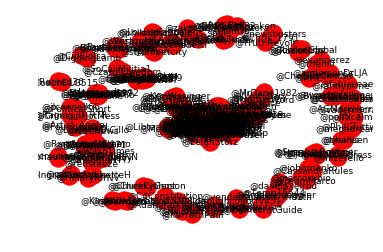

In [28]:
def create_a_graph_of_sum_of_users_being_together_in_a_tweet(target, print_it=False):
    mention_graph = nx.Graph()
    data = get_data_of_target_form_dataset(target, dataset)
    for tweet in data["Tweet"]:
        graph_mentions = get_mentions(tweet)
        if graph_mentions:
            #         for entity in entities:
            for pair in itertools.combinations(graph_mentions, 2):
                #             clone = entities.copy()
                #             clone.remove(entity)
                #             for entity_secondary in clone:
                entity = pair[0]
                entity_secondary = pair[1]
                if mention_graph.has_edge(entity, entity_secondary):
                    mention_graph.add_edge(
                        entity,
                        entity_secondary,
                        weight=mention_graph[entity][entity_secondary]["weight"] + 1,
                    )
                else:
                    mention_graph.add_edge(entity, entity_secondary, weight=1)
    if print_it:
        pos = nx.spring_layout(mention_graph)  # positions for all nodes
        nx.draw_networkx_labels(
            mention_graph, pos, font_size=9, font_family="sans-serif"
        )
        nx.draw(mention_graph, pos)
        labels = nx.get_edge_attributes(mention_graph, "weight")
        nx.draw_networkx_edge_labels(mention_graph, pos, edge_labels=labels)
        plt.show()
    return mention_graph


target = "Hillary Clinton"
mention_graph = create_a_graph_of_sum_of_users_being_together_in_a_tweet(target, True)

In [29]:
sorted_pagerank_centrality_mention_graph = sorted_pagerank_centrality(mention_graph)
print(sorted_pagerank_centrality_mention_graph[:20])

[['@HillaryClinton', 0.06699427264095244], ['@billclinton', 0.02618198930515646], ['@POTUS', 0.02618198930515646], ['@BarackObama', 0.01071066596815459], ['@BernieSanders', 0.008420435738953432], ['@realDonaldTrump', 0.006875263248932662], ['@DrMartyFox', 0.006475684396055533], ['@danmericaCNN', 0.006293896584240578], ['@CarmineZozzora', 0.0062451744569152106], ['@TheDemocrats', 0.0062109846868326195], ['@HillaryforIA', 0.006195130658460316], ['@pamnsc', 0.00618795050295642], ['@politico', 0.006073466256905472], ['@Lawrence', 0.005938337613827025], ['@Callisto1947', 0.005878959534105286], ['@StateDept', 0.005857075756494431], ['@joanwalsh', 0.005723716149607982], ['@tedcruz', 0.005705539100840639], ['@Chris_1791', 0.00569920954844581], ['@jstines3', 0.005657677574352655]]


In [30]:
sorted_closeness_centrality_mention_graph = sorted_closeness_centrality(mention_graph)
print(sorted_closeness_centrality_mention_graph[:20])

[['@HillaryClinton', 0.2666276889578839], ['@billclinton', 0.19058942210693183], ['@POTUS', 0.19058942210693183], ['@BernieSanders', 0.18988614010653726], ['@Babbsgirl2', 0.18055839989077752], ['@PolitiBunny', 0.17867758322524863], ['@Seja75', 0.17867758322524863], ['@hubbit', 0.17867758322524863], ['@MartinOMalley', 0.1774453240305917], ['@BarackObama', 0.17562847770945939], ['@StateDept', 0.17384845935429594], ['@realDonaldTrump', 0.17384845935429594], ['@HillaryforIA', 0.17326311100630168], ['@jstines3', 0.17268169117071006], ['@WoodenThreat', 0.17268169117071006], ['@AmbCathyRussell', 0.1721041604310087], ['@AdamSmith_USA', 0.1721041604310087], ['@politico', 0.1721041604310087], ['@GOP', 0.17153047989623868], ['@MaryMorientes', 0.17153047989623868]]


In [31]:
##Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
sorted_centrality_mention_graph = sorted_centrality(mention_graph)
print(sorted_centrality_mention_graph[:20])

[['@HillaryClinton', 0.17295719844357973], ['@BernieSanders', 0.04904851653696498], ['@Babbsgirl2', 0.031918774319066145], ['@DrMartyFox', 0.029608463035019454], ['@SenSanders', 0.022981517509727628], ['@Lawrence', 0.013497081712062257], ['@joanwalsh', 0.013497081712062257], ['@tedcruz', 0.010305204280155642], ['@TheDemocrats', 0.010274805447470817], ['@johnpodesta', 0.010214007782101167], ['@BarackObama', 0.008815661478599222], ['@realDonaldTrump', 0.007143725680933852], ['@GOP', 0.006900535019455253], ['@politico', 0.006900535019455253], ['@NRO', 0.006870136186770428], ['@jstines3', 0.00634727626459144], ['@billclinton', 0.005374513618677043], ['@POTUS', 0.005374513618677043], ['@HillaryforIA', 0.005091804474708171], ['@WoodenThreat', 0.003988326848249027]]


In [32]:
sorted_edge_centrality_mention_graph = sorted_edge_centrality(mention_graph)
print(sorted_edge_centrality_mention_graph[:20])

[[('@HillaryClinton', '@BernieSanders'), 0.04871354025276747], [('@DrMartyFox', '@Babbsgirl2'), 0.03197297378819413], [('@HillaryClinton', '@Babbsgirl2'), 0.028755567620828707], [('@BernieSanders', '@SenSanders'), 0.02461315718034567], [('@Lawrence', '@SenSanders'), 0.01643893463638283], [('@BernieSanders', '@joanwalsh'), 0.015383223237716043], [('@HillaryClinton', '@tedcruz'), 0.013513105902934877], [('@HillaryClinton', '@johnpodesta'), 0.013513105902934877], [('@TheDemocrats', '@DrMartyFox'), 0.013392453171658672], [('@HillaryClinton', '@BarackObama'), 0.01082104183633457], [('@NRO', '@johnpodesta'), 0.010225318975658312], [('@GOP', '@HillaryClinton'), 0.009772871233372546], [('@HillaryClinton', '@jstines3'), 0.009193738123246763], [('@HillaryClinton', '@politico'), 0.008023406629867584], [('@HillaryClinton', '@HillaryforIA'), 0.00781980514583899], [('@HillaryClinton', '@realDonaldTrump'), 0.00763128525321992], [('@Lawrence', '@JW4Hillary'), 0.0067565529514674386], [('@HillaryClinton

In [33]:
# degree_centrality which is defined as the number of links incident upon a node
sorted_by_degree_centrality_mention_graph = sorted_by_degree_centrality(mention_graph)
print(sorted_by_degree_centrality_mention_graph[:20])

[['@HillaryClinton', 0.2607003891050584], ['@billclinton', 0.07782101167315175], ['@POTUS', 0.07782101167315175], ['@BarackObama', 0.04669260700389105], ['@BernieSanders', 0.038910505836575876], ['@StateDept', 0.0311284046692607], ['@bristola48', 0.0311284046692607], ['@AlciniaH', 0.0311284046692607], ['@Mahogany1992', 0.0311284046692607], ['@stphil', 0.0311284046692607], ['@MzDivah67', 0.0311284046692607], ['@Progress4Ohio', 0.0311284046692607], ['@graceslick77', 0.0311284046692607], ['@AuntLulie', 0.0311284046692607], ['@deejayedee', 0.0311284046692607], ['@Callisto1947', 0.0311284046692607], ['@realDonaldTrump', 0.0311284046692607], ['@HillaryforIA', 0.027237354085603113], ['@jstines3', 0.027237354085603113], ['@WoodenThreat', 0.027237354085603113]]


In [34]:
# Eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network.
# It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes
# contribute more to the score of the node in question than equal connections to low-scoring nodes.
sorted_by_eigenvector_centrality_mention_graph = sorted_by_eigenvector_centrality(
    mention_graph
)
print(sorted_by_eigenvector_centrality_mention_graph[:20])

[['@HillaryClinton', 0.5661220633549133], ['@billclinton', 0.28998330980713716], ['@POTUS', 0.28998330980713716], ['@ProudInfidel33', 0.14598871592239135], ['@sunbeltgirl', 0.14480872929581512], ['@Network_Citizen', 0.13445185862555614], ['@YoungBLKRepub', 0.13445185862555614], ['@kin2souls', 0.13432907076085168], ['@ChristiChat', 0.13432907076085168], ['@WoodenThreat', 0.1339424517446632], ['@realDonaldTrump', 0.13029363439885575], ['@bobwilsonn', 0.12166841396964206], ['@politico', 0.12154101107665993], ['@anniekarni', 0.1205462513529274], ['@BarackObama', 0.11968995712204557], ['@FoxNews', 0.11509386583027335], ['@StateDept', 0.11352987603173242], ['@Babbsgirl2', 0.10906119026520868], ['@RedStateJake', 0.10802003875655175], ['@ResistTyranny', 0.10802003875655175]]


## Re reading the data

In [35]:
df = pd.read_csv("manual_data_updated.csv", index_col=0)
print(df.head())

              target         account  affiliated
0    Hillary Clinton  HillaryClinton        True
411  Hillary Clinton      JW4Hillary        True
125  Hillary Clinton        DNCWomen        True
164  Hillary Clinton   ClintonGlobal        True
300  Hillary Clinton    HillaryforSC        True


## Appending to the original data, the data from the graph we made

In [36]:
def find_value_from_name_from_list_of_2d_lists(name, list_to_search_from):
    name = "@" + name
    for sublist in list_to_search_from:
        if sublist[0] == name:
            return sublist[1]
    return 0


df["betweenness_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(i, sorted_centrality_mention_graph)
    for i in data["account"]
]
df["degree_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(
        i, sorted_by_degree_centrality_mention_graph
    )
    for i in data["account"]
]
df["eigenvector_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(
        i, sorted_by_eigenvector_centrality_mention_graph
    )
    for i in data["account"]
]
df["pagerank_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(
        i, sorted_pagerank_centrality_mention_graph
    )
    for i in data["account"]
]
df["closeness_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(
        i, sorted_closeness_centrality_mention_graph
    )
    for i in data["account"]
]

print(df)
print(len(df))

              target          account  affiliated  betweenness_centrality  \
0    Hillary Clinton   HillaryClinton        True                0.172957   
411  Hillary Clinton       JW4Hillary        True                0.003465   
125  Hillary Clinton         DNCWomen        True                0.000000   
164  Hillary Clinton    ClintonGlobal        True                0.000000   
300  Hillary Clinton     HillaryforSC        True                0.000000   
365  Hillary Clinton      billclinton        True                0.005375   
372  Hillary Clinton     HillaryforIA        True                0.005092   
375  Hillary Clinton     TheDemocrats        True                0.010275   
386  Hillary Clinton       ClintonFdn        True                0.000000   
388  Hillary Clinton      readyforHRC        True                0.000000   
390  Hillary Clinton   ChelseaClinton        True                0.000000   
402  Hillary Clinton    HillaryIn2016        True                0.000000   

In [37]:
df = df.sort_values(
    [
        "affiliated",
        "pagerank_centrality",
        "degree_centrality",
        "eigenvector_centrality",
    ],
    ascending=(False, False, False, False),
)
print(df.head())
df.to_csv("mannual_data_updated_with_graph_data.csv")

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
365  Hillary Clinton     billclinton        True                0.005375   
375  Hillary Clinton    TheDemocrats        True                0.010275   
372  Hillary Clinton    HillaryforIA        True                0.005092   
411  Hillary Clinton      JW4Hillary        True                0.003465   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700                0.566122             0.066994   
365           0.077821                0.289983             0.026182   
375           0.019455                0.001184             0.006211   
372           0.027237                0.095657             0.006195   
411           0.015564                0.000145             0.004671   

     closeness_centrality  
0                0.266628  
365              0.190589  
375              0.105449  
372 

In [38]:
b = df[df["betweenness_centrality"] != 0]
# print(b)
print(b.mean()[0])
b.to_csv("pairs_betweenness_centrality_findings.csv")

0.14285714285714285


In [39]:
b_only_affiliated = b[b["affiliated"] == True]
# print(b_only_affiliated)
b_only_affiliated_avg = b_only_affiliated["betweenness_centrality"].mean()
print(b_only_affiliated_avg)

0.03943275778210116


In [40]:
b_not_affiliated = b[b["affiliated"] == False]
# print(b_not_affiliated)
b_not_affiliated_avg = b_not_affiliated["betweenness_centrality"].mean()
print(b_not_affiliated_avg)

0.008188533560311283


In [41]:
d = df[df["degree_centrality"] != 0]
print(d.mean()[0])
d.to_csv("pairs_degree_centrality_findings.csv")

0.06201550387596899


In [42]:
d_only_affiliated = d[d["affiliated"] == True]
# print(d_only_affiliated)
d_only_affiliated_avg = d_only_affiliated["degree_centrality"].mean()
print(d_only_affiliated_avg)

0.0294260700389105


In [43]:
d_not_affiliated = d[d["affiliated"] == False]
# print(d_only_affiliated)
d_not_affiliated_avg = d_not_affiliated["degree_centrality"].mean()
print(d_not_affiliated_avg)

0.010563719972987728


In [44]:
e = df[df["eigenvector_centrality"] != 0]
print(e.mean()[0])
e.to_csv("pairs_eigenvector_centrality.csv")

0.06201550387596899


In [45]:
e_only_affiliated = e[e["affiliated"] == True]
# print(e_only_affiliated)
e_only_affiliated_avg = e_only_affiliated["eigenvector_centrality"].mean()
print(e_only_affiliated_avg)

0.0852748289090769


In [46]:
e_not_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
e_not_affiliated_avg = e_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [47]:
p_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
p_affiliated_avg = e_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [48]:
p_not_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
p_not_affiliated_avg = e_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [49]:
c_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
c_affiliated_avg = e_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [50]:
c_not_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
e_not_affiliated_avg = e_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [51]:
print(
    "so in conlcusion the affiliated accounts in pairs had ",
    str(b_only_affiliated_avg / float(b_not_affiliated_avg)),
    " betweenness centrality more",
)
print(
    "and the affiliated accounts in pairs had ",
    str(d_only_affiliated_avg / float(d_not_affiliated_avg)),
    " degree_centrality more",
)
print(
    "and lastly conlcusion the affiliated accounts in pairs had ",
    str(e_only_affiliated_avg / float(e_not_affiliated_avg)),
    " eigenvector_centrality more",
)
print(
    "and lastly conlcusion the affiliated accounts in pairs had ",
    str(e_only_affiliated_avg / float(e_not_affiliated_avg)),
    " pageranking more",
)
print(
    "and lastly conlcusion the affiliated accounts in pairs had ",
    str(e_only_affiliated_avg / float(e_not_affiliated_avg)),
    " closeness more",
)

so in conlcusion the affiliated accounts in pairs had  4.815606786204848  betweenness centrality more
and the affiliated accounts in pairs had  2.7855783866057884  degree_centrality more
and lastly conlcusion the affiliated accounts in pairs had  3.748789594830358  eigenvector_centrality more
and lastly conlcusion the affiliated accounts in pairs had  3.748789594830358  pageranking more
and lastly conlcusion the affiliated accounts in pairs had  3.748789594830358  closeness more


# Now lets do something like the above but not for a pair of users mentioned in the same tweet but with a single user.

### Create a dictionary which will map the entities i.e. @hillaryclinton another dictionary with a list of the tweets, a list of their respective sentiments, the number of hashtags, a list of the hashtags, number of user mentions, a list of user mentions and if it s are retweet in the tweet they  are in.


In [52]:
dict_for_users = {}
data_of_Hillary = get_data_of_target("Hillary Clinton")
print(len(data_of_Hillary))
for index, row in data_of_Hillary.iterrows():
    mentions = get_mentions(row["Tweet"])
    if mentions:
        hashtags = get_list_of_hashtags(row["Tweet"])
        for user in mentions:
            other_mentions = mentions.copy()
            other_mentions.remove(user)
            if not other_mentions:
                other_mentions = []
            key = user
            if key in dict_for_users:  # if pair already exists
                dict_for_users[key]["list_of_tweets"].append(row["Tweet"])
                dict_for_users[key]["list_of_sentiments"].append(row["Sentiment"])
                dict_for_users[key]["list_of_Stances"].append(row["Stance"])
                dict_for_users[key]["list_of_Opinion_Towards"].append(
                    row["Opinion towards"]
                )
                dict_for_users[key]["list_of_list_of_other_user_mentions"].append(
                    other_mentions
                )

                dict_for_users[key]["number_of_other_user_mentions"].append(
                    len(other_mentions)
                )

                dict_for_users[key]["list_of_list_of_the_hashtags"].append(hashtags)
                dict_for_users[key]["list_of_num_hashtags"].append(len(hashtags))
                dict_for_users[key]["retweet"].append(
                    True if row["Tweet"][0:2] == "RT" else False
                )

            else:  # if pair does not already exists
                dict_for_users[key] = {
                    "list_of_tweets": [row["Tweet"]],
                    "list_of_sentiments": [row["Sentiment"]],
                    "list_of_Stances": [row["Stance"]],
                    "list_of_Opinion_Towards": [row["Opinion towards"]],
                    "list_of_num_hashtags": [len(hashtags)],
                    "list_of_list_of_the_hashtags": [hashtags],
                    "number_of_other_user_mentions": [len(other_mentions)],
                    "list_of_list_of_other_user_mentions": [other_mentions],
                    "retweet": [True if row["Tweet"][0:2] == "RT" else False],
                }
# matplotlib everything to show better and compare with mine vs data
# mine affilited finnd in here and compare with the not
# print(dict_of_pairs)
nums = dict_for_users.items()
print(len(nums))
sorted_nums = sorted(nums, key=lambda x: len(x[1]["list_of_tweets"]), reverse=True)
list_nums = [
    str(i) + "\n\n " + str(len(i[1]["list_of_tweets"])) + "\n " for i in sorted_nums
]
print(list_nums)
count = 0
for i in list_nums:
    if count == 2:
        break
    print(i)
    print()
    count += 1

639
363
['(\'@HillaryClinton\', {\'list_of_tweets\': [\'@StateDept @AmbCathyRussell @AdamSmith_USA @HillaryClinton @HillaryforIA @BarackObama The whole #world is supporting you. #SemST\', \'Although I certainly have disagreements, after reading about @GovernorOMalley I much rather have him than @HillaryClinton. #SemST\', \'@HuffPostPol If @HillaryClinton can do half of what he did then she would be doing is a favor #SemST\', \'@HillaryClinton is at the top, and has spent her whole career growing government, keeping the deck stacked. #LibertyNotHillary #SemST\', \'@HillaryClinton i am portuguese and i support your campaign! Best luck! The world need a person and a women like you! #USA #SemST\', "This is not her first time at the rodeo!  @HillaryClinton doesn\'t care who likes her or not This woman is on a mission #Tough #SemST", "Wondering what the NEXT idiotic GOP smear against @HillaryClinton will be. It\'s coming for sure. Just don\'t know details yet. #SemST", \'Congratulations @Hil

In [53]:
sorted_most_mentioned_users = [
    ((i[0], len(i[1]["list_of_tweets"]))) for i in sorted_nums
]
print(sorted_most_mentioned_users[:10])

[('@HillaryClinton', 118), ('@POTUS', 15), ('@billclinton', 14), ('@GOP', 8), ('@BarackObama', 8), ('@realDonaldTrump', 8), ('@politico', 6), ('@FoxNews', 6), ('@BernieSanders', 6), ('@HillaryforIA', 4)]


# Now lets create new data with this individual users

## Re read the data

In [54]:
df_individual_users = pd.read_csv(
    "mannual_data_updated_with_graph_data.csv", index_col=0
)
print(df_individual_users.head())

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
365  Hillary Clinton     billclinton        True                0.005375   
375  Hillary Clinton    TheDemocrats        True                0.010275   
372  Hillary Clinton    HillaryforIA        True                0.005092   
411  Hillary Clinton      JW4Hillary        True                0.003465   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700                0.566122             0.066994   
365           0.077821                0.289983             0.026182   
375           0.019455                0.001184             0.006211   
372           0.027237                0.095657             0.006195   
411           0.015564                0.000145             0.004671   

     closeness_centrality  
0                0.266628  
365              0.190589  
375              0.105449  
372 

## create 3 helper functions that will help create the 3 new collumns:
### "num_of_tweets_they_appeared" total number of tweets they appeared
### "sentiments" they sentiment of the tweet they are in (POSITIVE, NEGATIVE)
### "list_of_Opinion_Towards" the opinion th tweet had on the target (FAVOR, AGAINST, NONE)

In [55]:
def find_value_from_name_from_list_of_2d_tuple(name,list_to_search_from):
    name = ('@'+name)
    for sublist in list_to_search_from:
        if sublist[0] ==name:
            return sublist[1]
    return 0
def count_sentiments(name,list_to_search_from ):
    sentiments = search_from_dict_target_list(name,'list_of_sentiments',list_to_search_from,)
    negative,positive = 0,0
    if sentiments: 
        for sent in sentiments:
            if sent == 'NEGATIVE':
                negative+=1
            else:
                positive+=1
        return  [positive,negative]

def count_opinion(name,list_to_search_from = list_nums):
    opinions = search_from_dict_target_list(name,'list_of_Stances',list_to_search_from,)
    favor,against,none = 0,0,0
    if opinions:
        for op in opinions:
#             print(op)
            if op == 'FAVOR':
                favor+=1
            elif op == 'AGAINST':
                against +=1
            else:
                none+=1
    return  [favor,against,none]

def search_from_dict_target_list(name, target,list_to_search_from = list_nums):
    name = ('@'+name)
    for sublist in list_to_search_from:
#         print(sublist)
        if sublist[0] ==name:
#             print("oleeeee")
            return sublist[1][target]
    

## Lets add the new collumns

In [56]:
df_individual_users['num_of_tweets_they_appeared'] = [find_value_from_name_from_list_of_2d_lists(i,sorted_most_mentioned_users) for i in df_individual_users['account']]
df_individual_users['sentiments'] = [count_sentiments(i,sorted_nums) for i in df_individual_users['account']]
df_individual_users['list_of_Opinion_Towards'] = [count_opinion(i,sorted_nums,) for i in df_individual_users['account']]

print(df_individual_users.head(10))
df_individual_users.to_csv('final_data_findings.csv')

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
365  Hillary Clinton     billclinton        True                0.005375   
375  Hillary Clinton    TheDemocrats        True                0.010275   
372  Hillary Clinton    HillaryforIA        True                0.005092   
411  Hillary Clinton      JW4Hillary        True                0.003465   
164  Hillary Clinton   ClintonGlobal        True                0.000000   
390  Hillary Clinton  ChelseaClinton        True                0.000000   
629  Hillary Clinton    HillaryforNV        True                0.000000   
300  Hillary Clinton    HillaryforSC        True                0.000000   
402  Hillary Clinton   HillaryIn2016        True                0.000000   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700            5.661221e-01             0.066994   
365           0.07782

## Lets see better the affiliated accounts

In [57]:
num_of_affiliated = df_individual_users[df_individual_users["affiliated"] == True]
print(num_of_affiliated.head(3))
count_affiliated = num_of_affiliated.count()[0]
print("\n\n", count_affiliated)

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
365  Hillary Clinton     billclinton        True                0.005375   
375  Hillary Clinton    TheDemocrats        True                0.010275   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700                0.566122             0.066994   
365           0.077821                0.289983             0.026182   
375           0.019455                0.001184             0.006211   

     closeness_centrality  num_of_tweets_they_appeared sentiments  \
0                0.266628                          118   [51, 67]   
365              0.190589                           14    [0, 14]   
375              0.105449                            4     [1, 3]   

    list_of_Opinion_Towards  
0               [43, 74, 1]  
365              [0, 14, 0]  
375               [1, 3, 0]  


 20


## Because they  are 20 and sorted I will get 10 of them and get the even numbered so 0 , 2 , 4 ... to represent the affiliated 

In [58]:
accounts_to_represent_affiliated = num_of_affiliated.iloc[
    :: (count_affiliated // 10), :
]
print(accounts_to_represent_affiliated)
print("\n\n", accounts_to_represent_affiliated.count()[0])

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
375  Hillary Clinton    TheDemocrats        True                0.010275   
411  Hillary Clinton      JW4Hillary        True                0.003465   
390  Hillary Clinton  ChelseaClinton        True                0.000000   
300  Hillary Clinton    HillaryforSC        True                0.000000   
559  Hillary Clinton    ARForHillary        True                0.000000   
125  Hillary Clinton        DNCWomen        True                0.000000   
523  Hillary Clinton      ca_hillary        True                0.000000   
386  Hillary Clinton      ClintonFdn        True                0.000000   
614  Hillary Clinton   HillaryHaikus        True                0.000000   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700            5.661221e-01             0.066994   
375           0.01945

## Lets see better the none affiliated accounts

In [59]:
num_of_not_affiliated = df_individual_users[df_individual_users["affiliated"] == False]
print(num_of_not_affiliated.head(3))
count_num_of_not_affiliated = num_of_not_affiliated.count()[0]
print("\n\n", count_num_of_not_affiliated)

            target        account  affiliated  betweenness_centrality  \
1  Hillary Clinton          POTUS       False                0.005375   
4  Hillary Clinton    BarackObama       False                0.008816   
8  Hillary Clinton  BernieSanders       False                0.049049   

   degree_centrality  eigenvector_centrality  pagerank_centrality  \
1           0.077821                0.289983             0.026182   
4           0.046693                0.119690             0.010711   
8           0.038911                0.085092             0.008420   

   closeness_centrality  num_of_tweets_they_appeared sentiments  \
1              0.190589                           15    [1, 14]   
4              0.175628                            8     [6, 2]   
8              0.189886                            6     [3, 3]   

  list_of_Opinion_Towards  
1              [0, 15, 0]  
4               [5, 0, 3]  
8               [2, 2, 2]  


 343


## Because they  are  and sorted I will get 11 of them with a step of floor(345/10) to represent the affiliated 

In [60]:
accounts_to_represent_not_affiliated = num_of_not_affiliated.iloc[
    :: (count_num_of_not_affiliated // 10), :
]
print(accounts_to_represent_not_affiliated)
print("\n\n", accounts_to_represent_not_affiliated.count()[0])

              target          account  affiliated  betweenness_centrality  \
1    Hillary Clinton            POTUS       False                0.005375   
456  Hillary Clinton     Mahogany1992       False                0.000000   
507  Hillary Clinton        putterrod       False                0.000000   
689  Hillary Clinton       skzdalimit       False                0.000000   
659  Hillary Clinton         TGowdySC       False                0.000000   
582  Hillary Clinton  LibtardLimbaugh       False                0.000000   
419  Hillary Clinton    oreillyfactor       False                0.000000   
719  Hillary Clinton   NumbersMuncher       False                0.000000   
550  Hillary Clinton        LaneLewis       False                0.000000   
724  Hillary Clinton   JessieJaneDuff       False                0.000000   
609  Hillary Clinton    CorrectRecord       False                0.000000   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
1   

## The Dataset for the chart

In [61]:
data_for_chart = pd.concat(
    [accounts_to_represent_affiliated, accounts_to_represent_not_affiliated],
    ignore_index=True,
    sort=False,
)
print(data_for_chart)

             target          account  affiliated  betweenness_centrality  \
0   Hillary Clinton   HillaryClinton        True                0.172957   
1   Hillary Clinton     TheDemocrats        True                0.010275   
2   Hillary Clinton       JW4Hillary        True                0.003465   
3   Hillary Clinton   ChelseaClinton        True                0.000000   
4   Hillary Clinton     HillaryforSC        True                0.000000   
5   Hillary Clinton     ARForHillary        True                0.000000   
6   Hillary Clinton         DNCWomen        True                0.000000   
7   Hillary Clinton       ca_hillary        True                0.000000   
8   Hillary Clinton       ClintonFdn        True                0.000000   
9   Hillary Clinton    HillaryHaikus        True                0.000000   
10  Hillary Clinton            POTUS       False                0.005375   
11  Hillary Clinton     Mahogany1992       False                0.000000   
12  Hillary 

## Lets make them in a list of lists format to help later with the analysis and graphing

In [62]:
lists_for_chart = []
for i in data_for_chart:
    lists_for_chart.append(data_for_chart[i].tolist())
# print(lists_for_chart)

## other than the graph stats(betweenness_centrality, degree_centrality, eigenvector_centrality) and num_of_tweets_they_appeared I will also sum the sentiments and opionions as favor/positive = +1 and against/negative = -1 and then divide the score by the num of tweets so that its normalized


In [63]:
accounts_for_chart = lists_for_chart[1]
betweenness_centrality_for_chart = lists_for_chart[3]
degree_centrality_for_chart = lists_for_chart[4]
eigenvector_centrality_for_chart = lists_for_chart[5]
num_of_tweets_they_appeared_for_chart = lists_for_chart[8]
pagerank_centrality_for_chart= lists_for_chart[6]
closeness_centrality_for_chart= lists_for_chart[7]
# print(pagerank_centrality_for_chart)
sentiments_for_chart =[i for i in lists_for_chart[-2]]
opinions_for_chart = lists_for_chart[-1]
# print(sentiments_for_chart)
# print(opinions_for_chart)
positives =[ i[0] for i in sentiments_for_chart]
negatives =[i[1] for i in sentiments_for_chart]
favor = [i[0] for i in opinions_for_chart]
against = [i[1] for i in opinions_for_chart]
none = [i[2] for i in opinions_for_chart]
# print(positives)
# print(negatives)
# print(favor) 
# print(against)
# print(none)
lists_sentiments = [positives, negatives]
lists_opinions = [favor, against, none]

sentiments_for_chart_merged = [val for pair in zip(*lists_sentiments) for val in pair]
# print(len(sentiments_for_chart_merged))
# print(sentiments_for_chart_merged)
   
sentiments_for_chart_sumed = [
    sentiments_for_chart_merged[i] - sentiments_for_chart_merged[i + 1]
    for i in range(0,int(len(sentiments_for_chart_merged)),2)
]
# print(sentiments_for_chart_sumed)
sentiments_for_chart_merged_normalized = [
    sentiments_for_chart_sumed[i] / num_of_tweets_they_appeared_for_chart[i]
    for i in range(len(num_of_tweets_they_appeared_for_chart))
]

opinions_for_chart_merged = [val for pair in zip(*lists_opinions) for val in pair]
opinions_for_chart_sumed = [
    opinions_for_chart_merged[i] - opinions_for_chart_merged[i + 1]
    for i in range(0,int(len(opinions_for_chart_merged)),3)
]

print(opinions_for_chart_merged)
print(opinions_for_chart_sumed)
opinions_for_chart_merged_normalized = [
    opinions_for_chart_sumed[i] / num_of_tweets_they_appeared_for_chart[i]
    for i in range(len(num_of_tweets_they_appeared_for_chart))
]
# print(opinions_for_chart_sumed)
# print(opinions_for_chart_merged_normalized)

[43, 74, 1, 1, 3, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 15, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]
[-31, -2, -2, 0, -1, 1, 1, 1, -2, -1, -15, 0, -1, 0, -1, 0, -1, -1, 0, -1, -1]


## Matplot graphs from the above findings

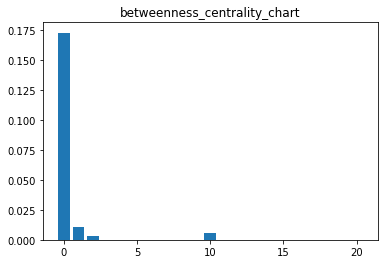

In [64]:
x_axis_locations = np.arange(data_for_chart.count()[0])
betweenness_centrality_chart = plt.bar(x_axis_locations, betweenness_centrality_for_chart,)
plt.title('betweenness_centrality_chart')
plt.show()

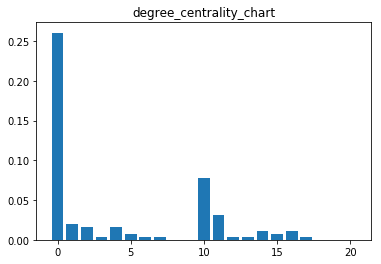

In [65]:
degree_centrality_chart= plt.bar(x_axis_locations, degree_centrality_for_chart)
plt.title('degree_centrality_chart')
plt.show()

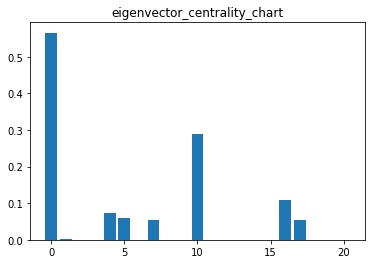

In [66]:
eigenvector_centrality_chart= plt.bar(x_axis_locations, eigenvector_centrality_for_chart)
plt.title('eigenvector_centrality_chart')
plt.show()

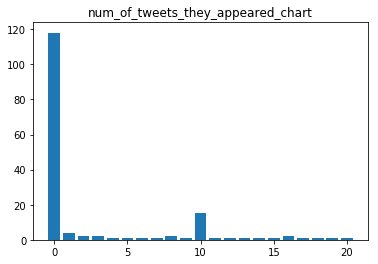

In [67]:
num_of_tweets_they_appeared_chart= plt.bar(x_axis_locations, num_of_tweets_they_appeared_for_chart)
plt.title('num_of_tweets_they_appeared_chart')
plt.show()

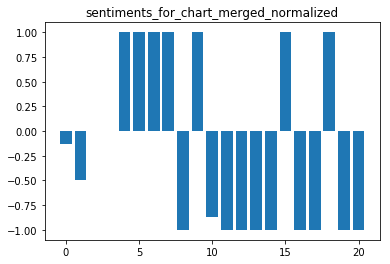

In [68]:
sentiments_for_chart_sumed_chart= plt.bar(x_axis_locations, sentiments_for_chart_merged_normalized)
plt.title('sentiments_for_chart_merged_normalized')
plt.show()

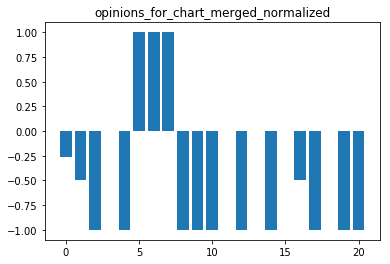

In [69]:
opinions_for_chart_sumed_chart= plt.bar(x_axis_locations,opinions_for_chart_merged_normalized)
plt.title('opinions_for_chart_merged_normalized')
plt.show()

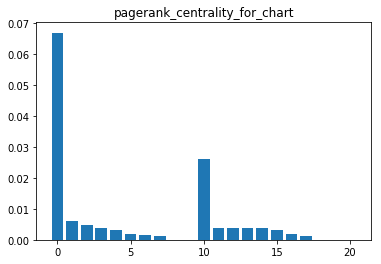

In [70]:
pagerank_chart= plt.bar(x_axis_locations,pagerank_centrality_for_chart)
plt.title('pagerank_centrality_for_chart')
plt.show()

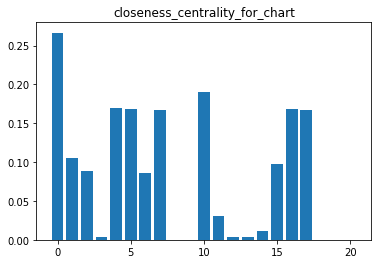

In [71]:
closeness_chart= plt.bar(x_axis_locations,closeness_centrality_for_chart)
plt.title('closeness_centrality_for_chart')
plt.show()

## After talking to my supervisor I have to change the data to help the machine learn better

## I'd rather have a row with a pair and their data instead of a single user  

In [72]:
edges = list(mention_graph.edges(data=True))
edges_in_list_form = [[i[0][1:],i[1][1:],i[2]['weight']] for i in edges]
pair_data = pd.DataFrame(edges_in_list_form, columns = ['Account1', 'Account2','Weight'])
# lower_account1= pair_data['Account1'].str.lower()
# lower_account2= pair_data['Account2'].str.lower()
# pair_data['account1'] = lower_account1
# pair_data['account2'] = lower_account2
pair_data.head()

,Account1,Account2,Weight
0,Chris_1791,newsbusters,1
1,Chris_1791,TruthRevolt,1
2,dnewhauser,GOP,1
3,GOP,spanglishpop,1
4,GOP,HillaryClinton,2


In [73]:
lookup_dataframe = df_individual_users.copy(deep = True)
lookup_dataframe.set_index("account", inplace=True)
lookup_dataframe

,target,affiliated,betweenness_centrality,degree_centrality,eigenvector_centrality,pagerank_centrality,closeness_centrality,num_of_tweets_they_appeared,sentiments,list_of_Opinion_Towards
account,,,,,,,,,,
HillaryClinton,Hillary Clinton,True,0.172957,0.260700,5.661221e-01,0.066994,0.266628,118,"[51, 67]","[43, 74, 1]"
billclinton,Hillary Clinton,True,0.005375,0.077821,2.899833e-01,0.026182,0.190589,14,"[0, 14]","[0, 14, 0]"
TheDemocrats,Hillary Clinton,True,0.010275,0.019455,1.183523e-03,0.006211,0.105449,4,"[1, 3]","[1, 3, 0]"
HillaryforIA,Hillary Clinton,True,0.005092,0.027237,9.565720e-02,0.006195,0.173263,4,"[4, 0]","[4, 0, 0]"
JW4Hillary,Hillary Clinton,True,0.003465,0.015564,1.449126e-04,0.004671,0.088876,2,"[1, 1]","[0, 2, 0]"
ClintonGlobal,Hillary Clinton,True,0.000000,0.007782,1.316940e-18,0.003876,0.007782,1,"[0, 1]","[0, 1, 0]"
ChelseaClinton,Hillary Clinton,True,0.000000,0.003891,1.030195e-23,0.003876,0.003891,2,"[1, 1]","[1, 1, 0]"
HillaryforNV,Hillary Clinton,True,0.000000,0.003891,1.030195e-23,0.003876,0.003891,1,"[1, 0]","[0, 1, 0]"
HillaryforSC,Hillary Clinton,True,0.000000,0.015564,7.439223e-02,0.003114,0.169273,1,"[1, 0]","[0, 1, 0]"


In [74]:
def check_if_accounts_are_affiliated(name1,name2):
    return lookup_dataframe.loc[name1]['affiliated'] and lookup_dataframe.loc[name2]['affiliated']
check_if_accounts_are_affiliated('HillaryClinton', 'billclinton')
Account1 = pair_data["Account1"].tolist()
Account2 = pair_data["Account2"].tolist()
# print(Account1)
list_affiliated = [check_if_accounts_are_affiliated(Account1[i],Account2[i]) for i in range(len(Account1))]
pair_data['both_affiliated'] = list_affiliated
pair_data

,Account1,Account2,Weight,both_affiliated
0,Chris_1791,newsbusters,1,False
1,Chris_1791,TruthRevolt,1,False
2,dnewhauser,GOP,1,False
3,GOP,spanglishpop,1,False
4,GOP,HillaryClinton,2,False
5,GOP,realDonaldTrump,1,False
6,StateDept,AmbCathyRussell,1,False
7,StateDept,AdamSmith_USA,1,False
8,StateDept,HillaryClinton,2,False
9,StateDept,HillaryforIA,1,False


In [75]:
temp = nx.edge_betweenness_centrality(mention_graph)
list_of_edge_betweenness_centrality = [temp[i] for i in temp]
pair_data['edge_betweenness_centrality'] = list_of_edge_betweenness_centrality

In [76]:
nodes_centralities = [
    [lookup_dataframe.loc[Account1[i]][2:10]] for i in range(len(Account1))
]
# print(nodes_centralities[0][0][0])
# print(nodes_centralities[:2])
nodes_betweenness_centrality = [
    nodes_centralities[i][0][0] for i in range(len(Account1))
]
nodes_degree_centrality                 = [
    nodes_centralities[i][0][1] for i in range(len(Account1))
]
nodes_eigenvector_centrality = [
    nodes_centralities[i][0][2] for i in range(len(Account1))
]
# print(nodes_eigenvector_centrality[:3])
nodes_pagerank_centrality = [nodes_centralities[i][0][3] for i in range(len(Account1))]
nodes_closeness_centrality = [nodes_centralities[i][0][4] for i in range(len(Account1))]
nodes_num_of_tweets_they_appeared = [
    nodes_centralities[i][0][5] for i in range(len(Account1))
]
nodes_sentiments_sumed = [
    nodes_centralities[i][0][6][0] - nodes_centralities[i][0][6][1]
    for i in range(len(Account1))
]
nodes_opinions_sumed = [
    nodes_centralities[i][0][7][0] - nodes_centralities[i][0][7][1]
    for i in range(len(Account1))
]
pair_data['account1_betweenness_centrality'] = nodes_betweenness_centrality
pair_data['account1_degree_centrality'] = nodes_degree_centrality
pair_data['account1_eigenvector_centrality'] = nodes_eigenvector_centrality
pair_data['account1_pagerank_centrality'] = nodes_pagerank_centrality
pair_data['account1_closeness_centrality'] = nodes_closeness_centrality
pair_data['account1_num_of_tweets_they_appeared'] = nodes_num_of_tweets_they_appeared
pair_data['account1_sentiments_sumed'] = nodes_sentiments_sumed
pair_data['account1_opinions_sumed'] = nodes_opinions_sumed



In [77]:
nodes_centralities = [
    [lookup_dataframe.loc[Account2[i]][2:10]] for i in range(len(Account2))
]
# print(nodes_centralities[0][0][0])
# print(nodes_centralities[:2])
nodes_betweenness_centrality = [
    nodes_centralities[i][0][0] for i in range(len(Account1))
]
nodes_degree_centrality                 = [
    nodes_centralities[i][0][1] for i in range(len(Account1))
]
nodes_eigenvector_centrality = [
    nodes_centralities[i][0][2] for i in range(len(Account1))
]
# print(nodes_eigenvector_centrality[:3])
nodes_pagerank_centrality = [nodes_centralities[i][0][3] for i in range(len(Account1))]
nodes_closeness_centrality = [nodes_centralities[i][0][4] for i in range(len(Account1))]
nodes_num_of_tweets_they_appeared = [
    nodes_centralities[i][0][5] for i in range(len(Account1))
]
nodes_sentiments_sumed = [
    nodes_centralities[i][0][6][0] - nodes_centralities[i][0][6][1]
    for i in range(len(Account1))
]
nodes_opinions_sumed = [
    nodes_centralities[i][0][7][0] - nodes_centralities[i][0][7][1]
    for i in range(len(Account1))
]
pair_data['account2_betweenness_centrality'] = nodes_betweenness_centrality
pair_data['account2_degree_centrality'] = nodes_degree_centrality
pair_data['account2_eigenvector_centrality'] = nodes_eigenvector_centrality
pair_data['account2_pagerank_centrality'] = nodes_pagerank_centrality
pair_data['account2_closeness_centrality'] = nodes_closeness_centrality
pair_data['account2_num_of_tweets_they_appeared'] = nodes_num_of_tweets_they_appeared
pair_data['account2_sentiments_sumed'] = nodes_sentiments_sumed
pair_data['account2_opinions_sumed'] = nodes_opinions_sumed
pair_data

,Account1,Account2,Weight,both_affiliated,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_closeness_centrality,...,account1_sentiments_sumed,account1_opinions_sumed,account2_betweenness_centrality,account2_degree_centrality,account2_eigenvector_centrality,account2_pagerank_centrality,account2_closeness_centrality,account2_num_of_tweets_they_appeared,account2_sentiments_sumed,account2_opinions_sumed
0,Chris_1791,newsbusters,1,False,0.000060,0.000030,0.007782,2.919377e-21,0.005699,0.007782,...,-2,-1,0.000000,0.003891,2.064311e-21,0.002964,0.005188,1,-1,-1
1,Chris_1791,TruthRevolt,1,False,0.000060,0.000030,0.007782,2.919377e-21,0.005699,0.007782,...,-2,-1,0.000000,0.003891,2.064311e-21,0.002964,0.005188,1,-1,0
2,dnewhauser,GOP,1,False,0.003469,0.000000,0.003891,6.298342e-03,0.001374,0.124297,...,-1,0,0.006901,0.015564,6.682515e-02,0.004661,0.171530,8,-6,-5
3,GOP,spanglishpop,1,False,0.003469,0.006901,0.015564,6.682515e-02,0.004661,0.171530,...,-6,-5,0.000000,0.003891,6.298342e-03,0.001374,0.124297,1,-1,0
4,GOP,HillaryClinton,2,False,0.009773,0.006901,0.015564,6.682515e-02,0.004661,0.171530,...,-6,-5,0.172957,0.260700,5.661221e-01,0.066994,0.266628,118,-16,-31
5,GOP,realDonaldTrump,1,False,0.000452,0.006901,0.015564,6.682515e-02,0.004661,0.171530,...,-6,-5,0.007144,0.031128,1.302936e-01,0.006875,0.173848,8,-4,-2
6,StateDept,AmbCathyRussell,1,False,0.000075,0.000365,0.031128,1.135299e-01,0.005857,0.173848,...,0,0,0.000000,0.019455,9.313243e-02,0.003417,0.172104,1,1,1
7,StateDept,AdamSmith_USA,1,False,0.000075,0.000365,0.031128,1.135299e-01,0.005857,0.173848,...,0,0,0.000000,0.019455,9.313243e-02,0.003417,0.172104,1,1,1
8,StateDept,HillaryClinton,2,False,0.003092,0.000365,0.031128,1.135299e-01,0.005857,0.173848,...,0,0,0.172957,0.260700,5.661221e-01,0.066994,0.266628,118,-16,-31
9,StateDept,HillaryforIA,1,False,0.000189,0.000365,0.031128,1.135299e-01,0.005857,0.173848,...,0,0,0.005092,0.027237,9.565720e-02,0.006195,0.173263,4,4,4


In [78]:
print(pair_data.count()[0])
pair_data = pair_data[pair_data.account2_num_of_tweets_they_appeared >1]
pair_data = pair_data[pair_data.account1_num_of_tweets_they_appeared >1]
pair_data['Account1'] = pair_data.Account1.str.lower()
pair_data['Account2'] = pair_data.Account2.str.lower()
# print(pair_data)
print(pair_data.count()[0])

389
75


## Time to use Feature selector to help understand the above data

### Shuffle em

In [79]:
all_data = pair_data
all_data = all_data.sample(frac=1).reset_index(drop=True)
# print(all_data.head(2))

In [80]:
train_labels = all_data['both_affiliated']
train = all_data.drop(columns = ['both_affiliated'])
fs = FeatureSelector(data = train, labels = train_labels)

In [81]:
fs.identify_missing(missing_threshold=0.6)
missing_features = fs.ops['missing']
missing_features

0 features with greater than 0.60 missing values.



[]

In [82]:
fs.identify_single_unique()
single_unique = fs.ops['single_unique']
single_unique
fs.remove(methods=['single_unique'])

0 features with a single unique value.

Removed 0 features.


,Account1,Account2,Weight,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_closeness_centrality,account1_num_of_tweets_they_appeared,account1_sentiments_sumed,account1_opinions_sumed,account2_betweenness_centrality,account2_degree_centrality,account2_eigenvector_centrality,account2_pagerank_centrality,account2_closeness_centrality,account2_num_of_tweets_they_appeared,account2_sentiments_sumed,account2_opinions_sumed
0,hillaryclinton,barackobama,3,0.010821,0.172957,0.260700,5.661221e-01,0.066994,0.266628,118,-16,-31,0.008816,0.046693,1.196900e-01,0.010711,0.175628,8,4,5
1,billclinton,anniekarni,1,0.000674,0.005375,0.077821,2.899833e-01,0.026182,0.190589,14,-14,-14,0.003465,0.019455,1.205463e-01,0.003629,0.171530,2,0,-2
2,realdonaldtrump,billclinton,1,0.001146,0.007144,0.031128,1.302936e-01,0.006875,0.173848,8,-4,-2,0.005375,0.077821,2.899833e-01,0.026182,0.190589,14,-14,-14
3,woodenthreat,billclinton,1,0.000914,0.003988,0.027237,1.339425e-01,0.004655,0.172682,2,-2,-2,0.005375,0.077821,2.899833e-01,0.026182,0.190589,14,-14,-14
4,politico,billclinton,2,0.001010,0.006901,0.023346,1.215410e-01,0.006073,0.172104,6,-4,-3,0.005375,0.077821,2.899833e-01,0.026182,0.190589,14,-14,-14
5,todayshow,chrischristie,1,0.000030,0.000000,0.003891,1.030195e-23,0.003876,0.003891,2,-2,-2,0.000000,0.003891,1.030195e-23,0.003876,0.003891,3,-3,-1
6,govchristie,foxnews,1,0.000090,0.000000,0.007782,6.420531e-02,0.002276,0.168719,2,-2,-2,0.003496,0.019455,1.150939e-01,0.004234,0.170395,6,-6,-6
7,politico,potus,2,0.001010,0.006901,0.023346,1.215410e-01,0.006073,0.172104,6,-4,-3,0.005375,0.077821,2.899833e-01,0.026182,0.190589,15,-13,-15
8,woodenthreat,proudinfidel33,1,0.000160,0.003988,0.027237,1.339425e-01,0.004655,0.172682,2,-2,-2,0.000040,0.023346,1.459887e-01,0.005090,0.171530,2,-2,-2
9,statedept,barackobama,1,0.000309,0.000365,0.031128,1.135299e-01,0.005857,0.173848,2,0,0,0.008816,0.046693,1.196900e-01,0.010711,0.175628,8,4,5


In [83]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[121]	valid_0's auc: 0.818182
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's auc: 0.909091
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	valid_0's auc: 0.863636
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0

In [84]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
one_hot_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 20 original features
There are 63 one-hot features


## Time to make the above runnable and create a database to store the tweets I get and etrive them to process them

### Disclaimer: This will only be ran once to create the database in in the notebook I will have in comments what ahoukd have been done in an executable. So The actual script will be ran on pycharm instead. But here we will have the code it has to show what we did.

In [ ]:
# myclient = pymongo.MongoClient("mongodb://localhost:27017/")

# mydb = myclient["Affiliated_DB"]
# mycol = mydb["tweets"]